
# Weather Classification Analysis for Wildfire Avoidance

As an Environmental Engineer deeply invested in leveraging data science for environmental recovery, especially in high-risk areas like those prone to wildfires, this project resonates with my core mission. My analytical approach drives me to break down complex environmental challenges into manageable data problems. Here, I apply machine learning to predict dry weather conditions, a critical step in proactive wildfire prevention and resource management. This work is a step-by-step exploration, connecting technical skills with the vital goal of protecting our ecosystems and communities.

This notebook performs data preparation, including basic inspection, cleaning, exploratory data analysis (EDA), and feature engineering, for a weather classification dataset. The goal is to predict dryness trends for wildfire avoidance, with 'Dry' conditions defined based on parameters relevant to the Canadian Forest Fire Weather Index (FWI) system. It also includes statistical tests to understand the relationships between features and dryness.


In [146]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For statistical tests
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("weather_classification_data.csv")



## 1. Basic Inspection

My first step in any data project is to get a foundational understanding of the dataset. This involves a quick look at the first few rows, checking the overall size, and examining the data types to ensure everything is as expected. It's like surveying the landscape before starting an environmental assessment.


In [147]:

print("---Checking Head Rows---")
df.head()


---Checking Head Rows---


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [148]:
print("\n---Checking Rows and Columns---")
print(df.shape)
print("\n---Checking Data Types---")
print(df.dtypes)
print("\n---Checking Dataset Info---")
df.info()


---Checking Rows and Columns---
(13200, 11)

---Checking Data Types---
Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
Weather Type             object
dtype: object

---Checking Dataset Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index   


## 2. Data Cleaning

Just as environmental remediation starts with removing contaminants, data cleaning is about ensuring the integrity of our dataset. Here, I focus on identifying and addressing duplicate entries and missing values, which can skew our analysis and model performance.


In [149]:

print("---Checking for duplicates---")
print(f"{df.duplicated().sum()} duplicates found.")
df.drop_duplicates(inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


---Checking for duplicates---
0 duplicates found.
Shape after dropping duplicates: (13200, 11)

Missing values per column:
Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64



## 3. Feature Engineering: Define Dryness Target Variable for Wildfire Avoidance

This is where I connect the raw weather data to a real-world environmental problem: wildfire risk. By defining 'Dry' conditions based on principles from the Canadian Forest Fire Weather Index (FWI) system, I'm creating a target variable that directly supports our goal of wildfire avoidance. It's about translating environmental indicators into actionable data points.



#### Based on FWI system inputs: temperature, relative humidity, wind speed, and 24-hour precipitation.

*   A simplified definition of 'Dry' for wildfire avoidance:
    -   Low Precipitation
    -   Low Humidity
    -   High Temperature
    -   Potentially High Wind Speed (though not directly used in this simple binary definition)

*   Define thresholds for 'Dry' conditions based on FWI inputs (these are illustrative and can be refined)
*   Let's consider 'Dry' if:
    -   Precipitation (%) < 10 (very low precipitation)
    -   Humidity < 50 (low humidity)
    -   Temperature > 25 (high temperature)



    __More details for FWI system on the PDF report__


In [ ]:

def define_dryness_for_wildfire(row):
    if row["Precipitation (%)"] < 10 and row["Humidity"] < 50 and row["Temperature"] > 25:
        return "Dry"
    else:
        return "Not Dry"

df["Dryness_Label_Wildfire"] = df.apply(define_dryness_for_wildfire, axis=1)
print("\nValue counts for Dryness_Label_Wildfire:")
print(df["Dryness_Label_Wildfire"].value_counts())

# Target variable for classification (1 for Dry, 0 for Not Dry)
y = (df["Dryness_Label_Wildfire"] == "Dry").astype(int)

# Features (excluding original Weather Type and the new Dryness_Label_Wildfire)
x = df.drop(["Weather Type", "Dryness_Label_Wildfire"], axis=1)



Value counts for Dryness_Label_Wildfire:
Dryness_Label_Wildfire
Not Dry    12618
Dry          582
Name: count, dtype: int64


In [188]:
print(df["Dryness_Label_Wildfire"].unique())

print(y.unique())

['Not Dry' 'Dry']
[0 1]



## 4. Exploratory Data Analysis (EDA)

This section is my deep dive into the data, much like a field investigation. I use visualizations and statistical tests to uncover patterns and relationships, especially those that shed light on wildfire risk factors. Understanding these connections is crucial for building a robust predictive model and ensuring our insights are grounded in evidence.


In [189]:
x.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73.0,9.5,82.0,partly cloudy,1010.82,2.0,Winter,3.5,inland
1,39.0,96.0,8.5,71.0,partly cloudy,1011.43,7.0,Spring,10.0,inland
2,30.0,64.0,7.0,16.0,clear,1018.72,5.0,Spring,5.5,mountain
3,38.0,83.0,1.5,82.0,clear,1026.25,7.0,Spring,1.0,coastal
4,27.0,74.0,17.0,66.0,overcast,990.67,1.0,Winter,2.5,mountain



--- Exploratory Data Analysis (Visualizations and Statistical Tests) ---
Outliers in Temperature handled by capping.
Outliers in Humidity handled by capping.
Outliers in Wind Speed handled by capping.
Outliers in Precipitation (%) handled by capping.
Outliers in Atmospheric Pressure handled by capping.
Outliers in UV Index handled by capping.
Outliers in Visibility (km) handled by capping.

--- Statistical Tests for Dryness ---

Temperature - T-test (Dry vs. Not Dry):
  Statistic: 60.965
  P-value: 0.000
  Conclusion: Significant difference in Temperature between Dry and Not Dry groups (p < 0.05)

Humidity - T-test (Dry vs. Not Dry):
  Statistic: -87.417
  P-value: 0.000
  Conclusion: Significant difference in Humidity between Dry and Not Dry groups (p < 0.05)

Precipitation (%) - T-test (Dry vs. Not Dry):
  Statistic: -172.391
  P-value: 0.000
  Conclusion: Significant difference in Precipitation (%) between Dry and Not Dry groups (p < 0.05)

Wind Speed - T-test (Dry vs. Not Dry):
  

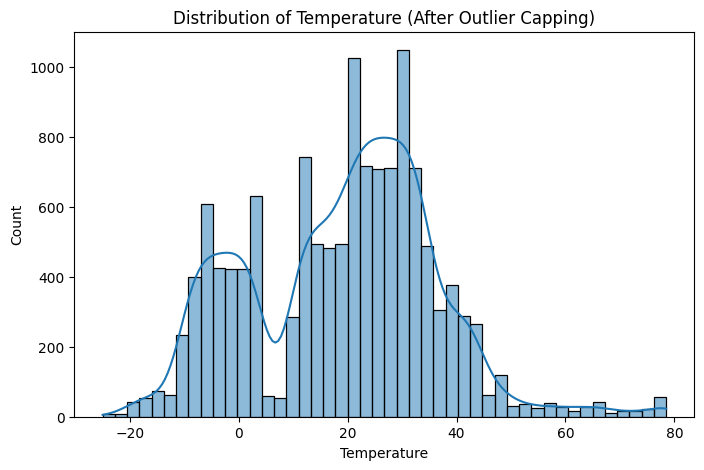

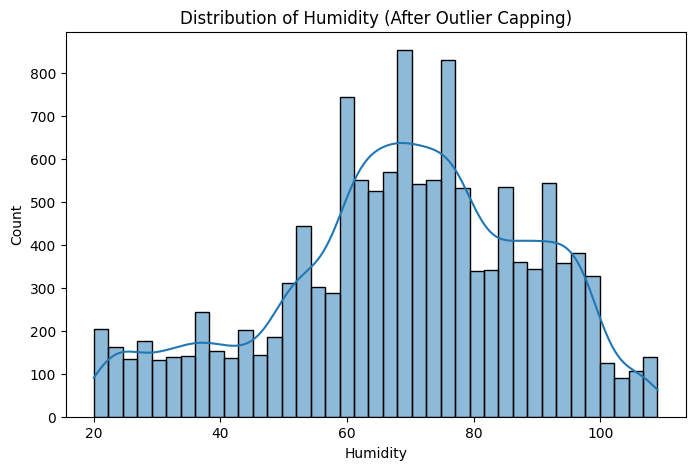

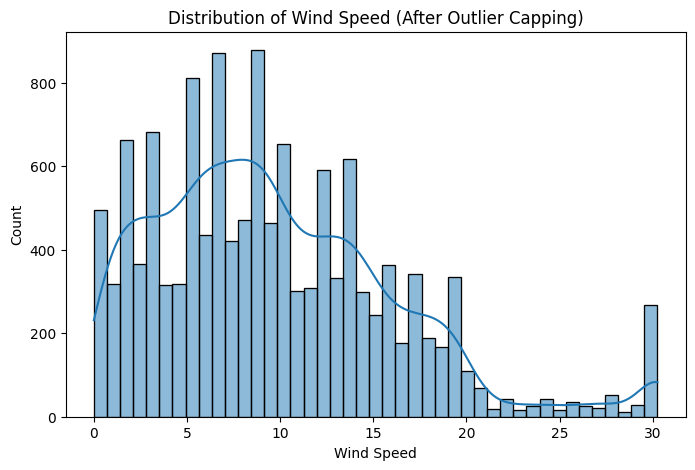

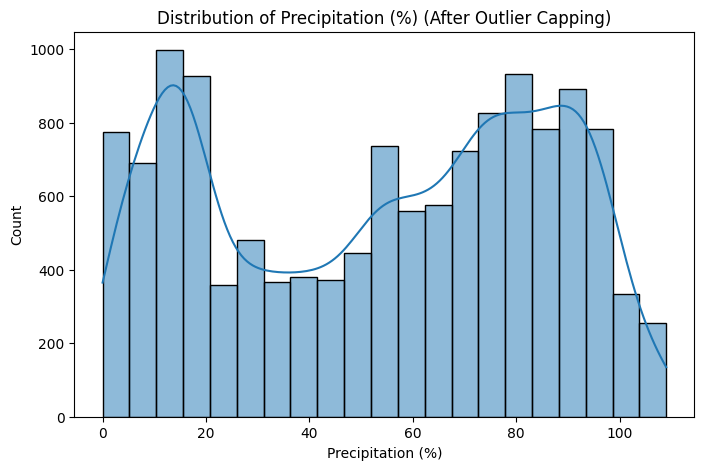

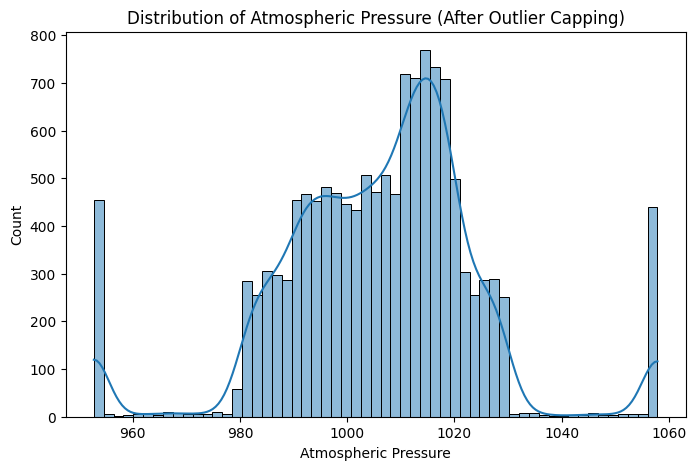

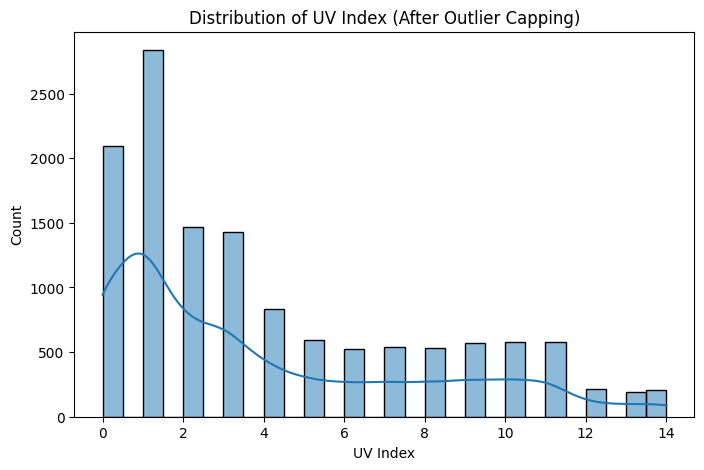

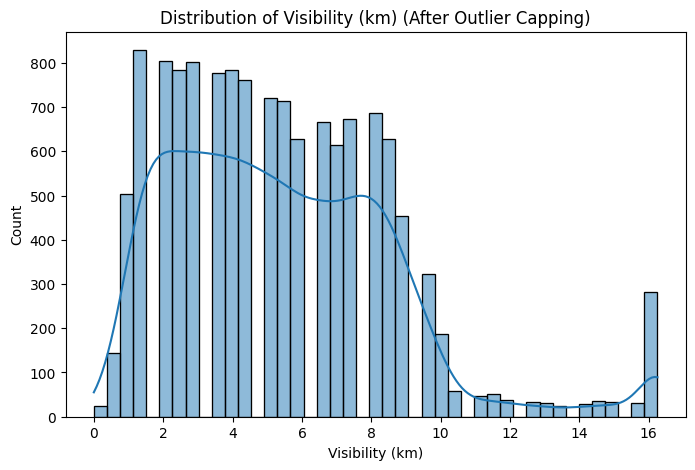

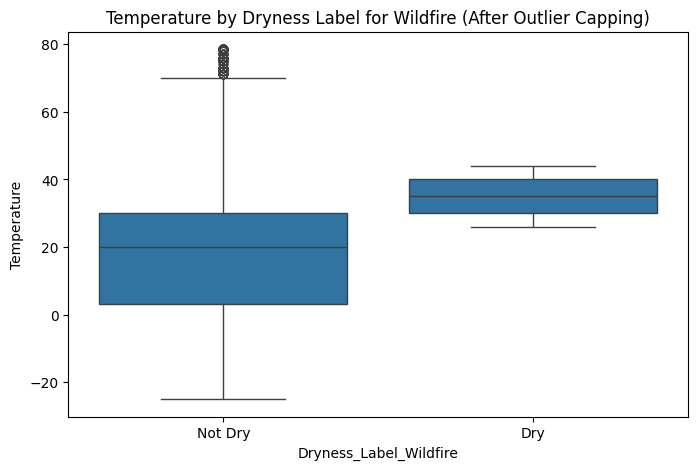

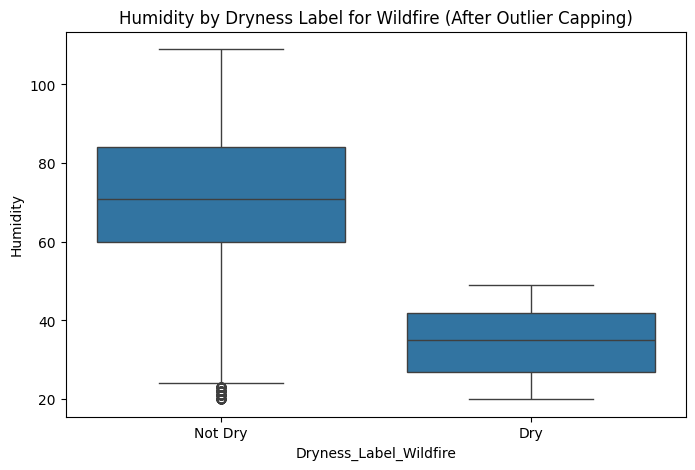

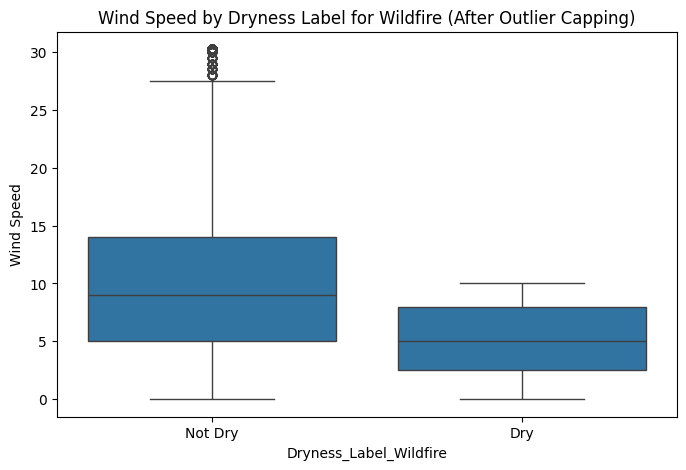

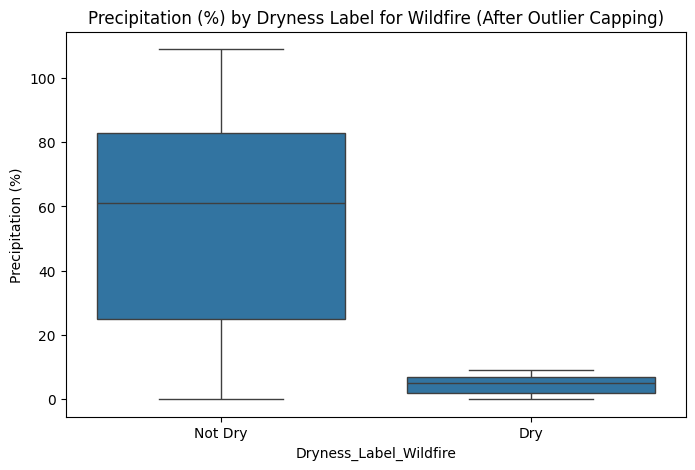

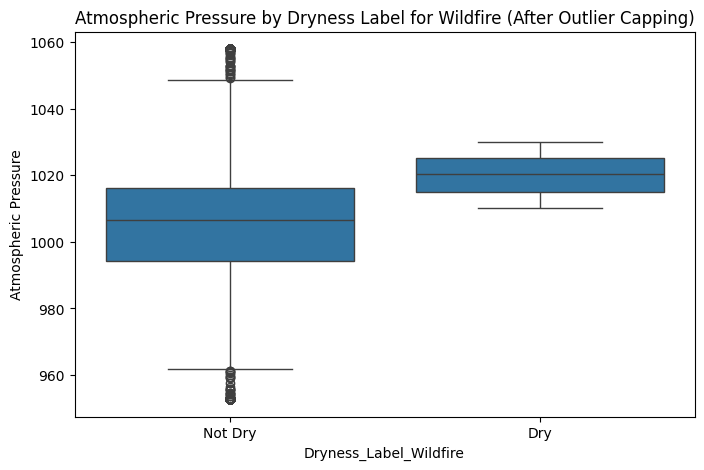

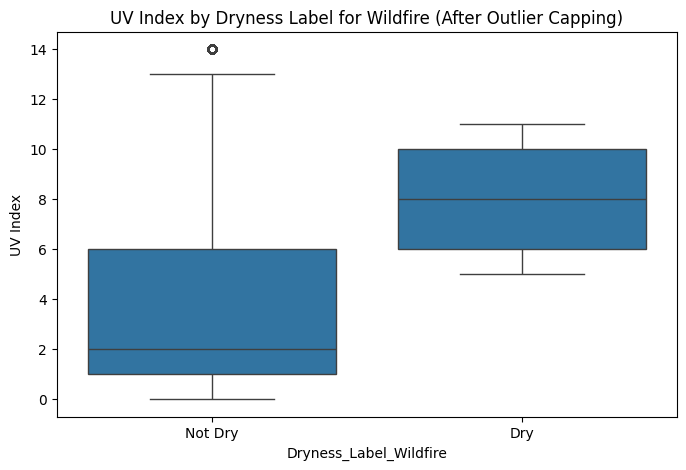

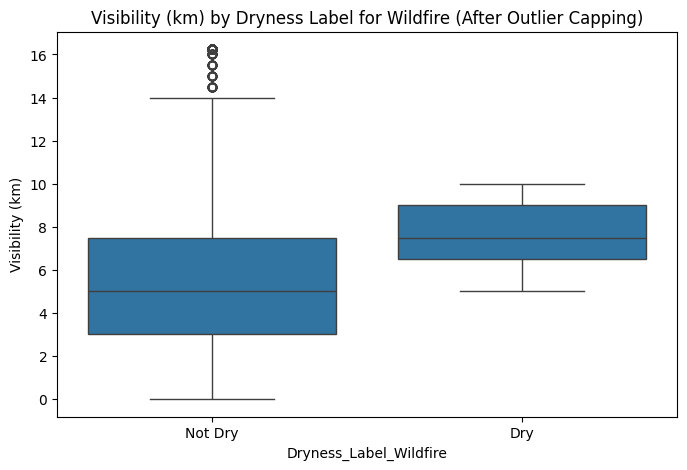

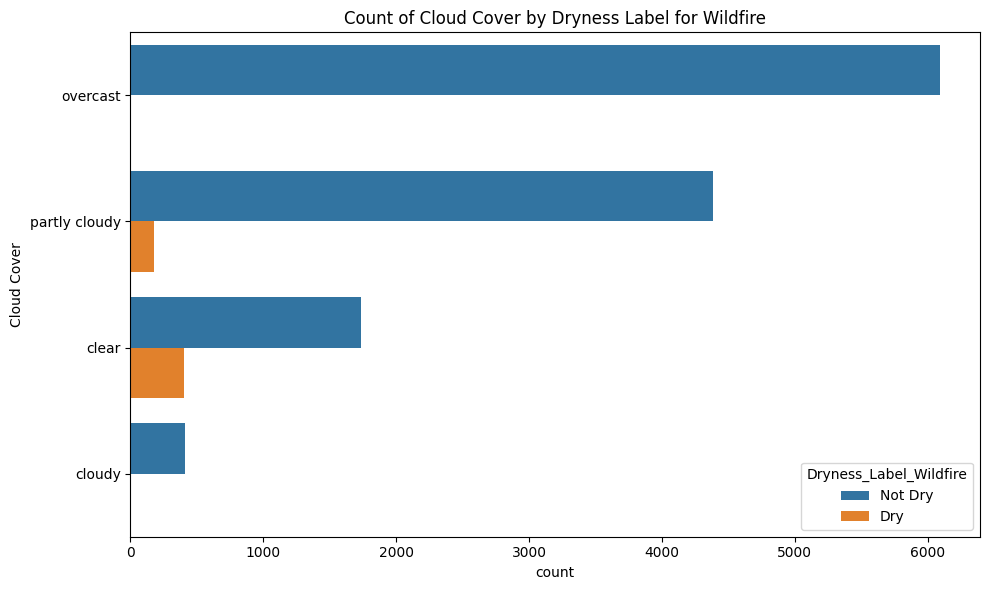

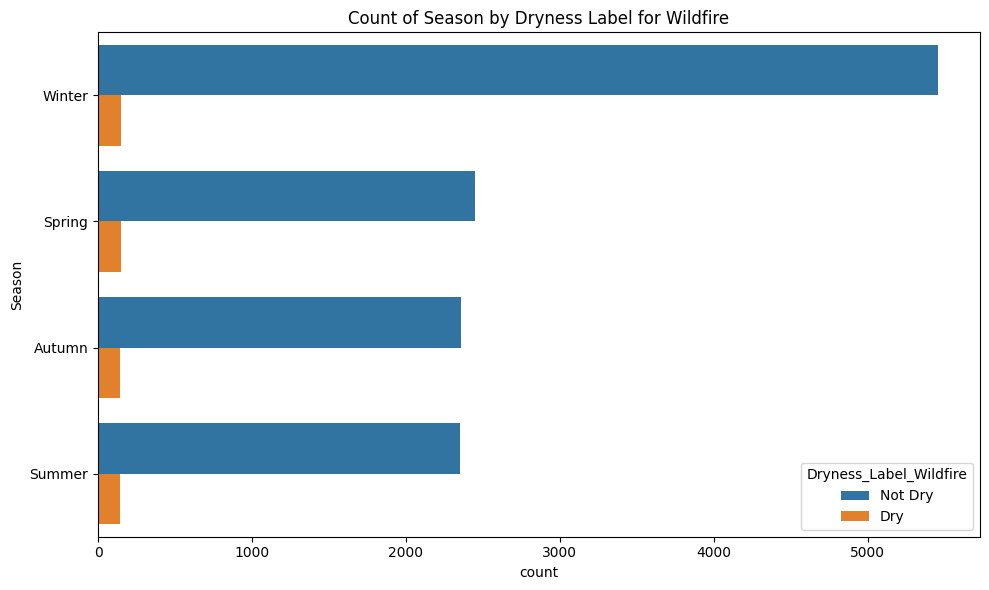

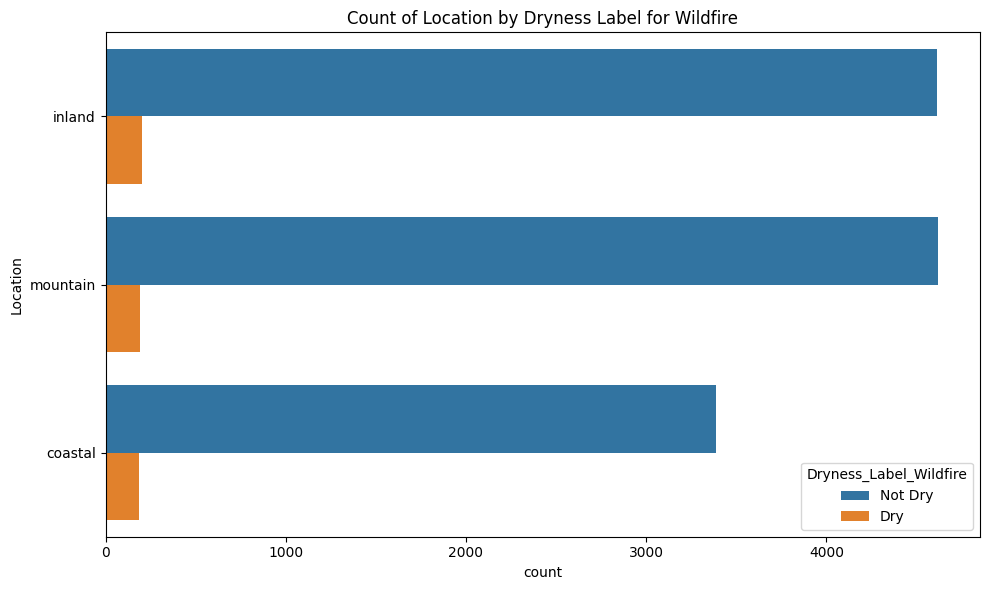

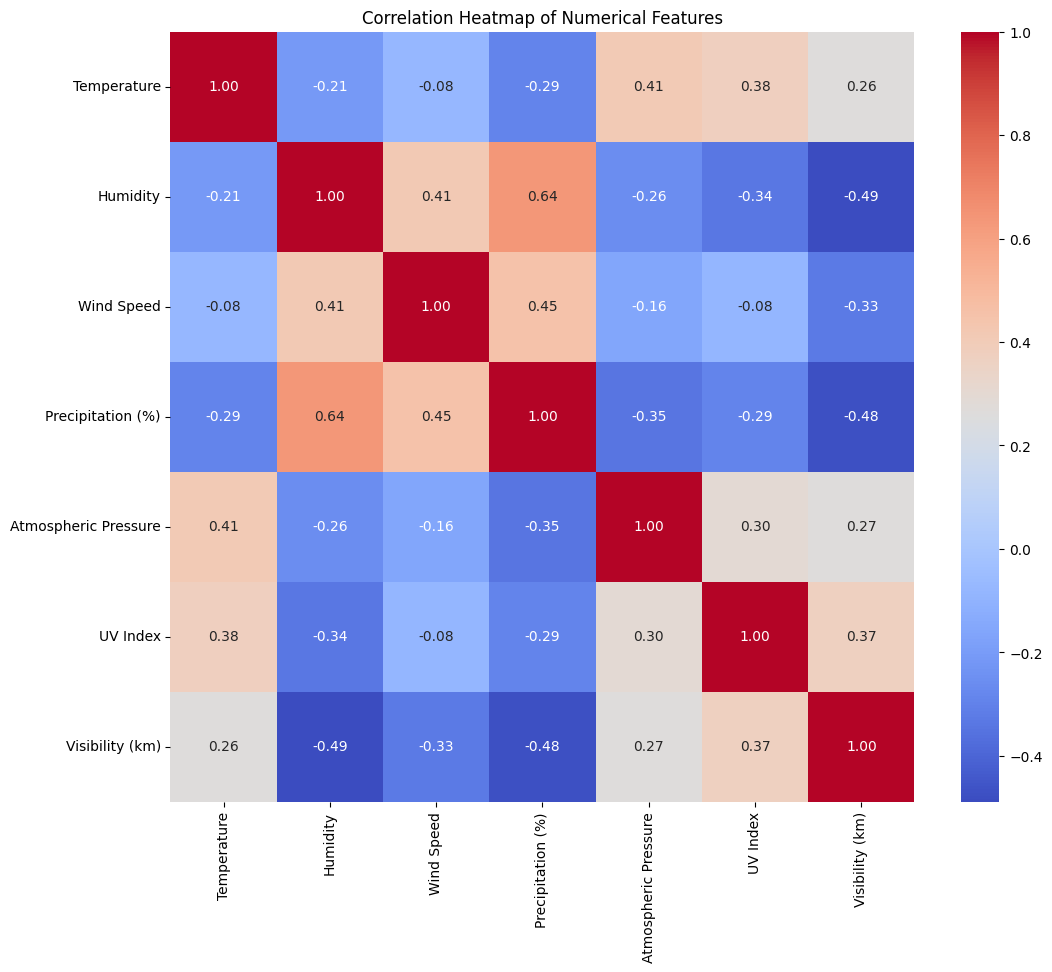

In [190]:

print("\n--- Exploratory Data Analysis (Visualizations and Statistical Tests) ---")

# Identify numerical and categorical features
numerical_features = x.select_dtypes(include=np.number).columns
categorical_features = x.select_dtypes(include="object").columns

# Outlier Handling (Capping using IQR method)
# This approach helps to mitigate the impact of extreme values without removing data points,
# which is often preferred in environmental data where outliers might represent real, albeit rare, events.
for col in numerical_features:
    Q1 = df[col].quantile(0.20)
    Q3 = df[col].quantile(0.80)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    print(f"Outliers in {col} handled by capping.")

# Histograms for numerical features (after outlier handling)
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col} (After Outlier Capping)")
    #plt.show()

# Box plots for numerical features comparing with Dryness_Label_Wildfire feature
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df["Dryness_Label_Wildfire"], y=df[col])
    plt.title(f"{col} by Dryness Label for Wildfire (After Outlier Capping)")
    #plt.show()

# Plots for categorical features
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y=col, hue="Dryness_Label_Wildfire", order = df[col].value_counts().index)
    plt.title(f"Count of {col} by Dryness Label for Wildfire")
    plt.tight_layout()
    #plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
#plt.show()

# --- Statistical Tests for Dryness --- 
print("\n--- Statistical Tests for Dryness ---")

dry_group = df[df["Dryness_Label_Wildfire"] == "Dry"]
not_dry_group = df[df["Dryness_Label_Wildfire"] == "Not Dry"]

# T-tests for key numerical features (Temperature, Humidity, Precipitation (%), Wind Speed)
# to see if their means are significantly different between Dry and Not Dry groups.
# Assuming data is not strictly normal, but t-test is robust for large samples.
# For non-normal data, Mann-Whitney U test could be used.
key_fwi_features = ["Temperature", "Humidity", "Precipitation (%)", "Wind Speed"]

for feature in key_fwi_features:
    stat, p = stats.ttest_ind(dry_group[feature], not_dry_group[feature], equal_var=False) # t-test
    print(f"\n{feature} - T-test (Dry vs. Not Dry):")
    print(f"  Statistic: {stat:.3f}")
    print(f"  P-value: {p:.3f}")
    if p < 0.05:
        print(f"  Conclusion: Significant difference in {feature} between Dry and Not Dry groups (p < 0.05)")
    else:
        print(f"  Conclusion: No significant difference in {feature} between Dry and Not Dry groups (p >= 0.05)")

# Chi-squared test for categorical features (Season, Location, Cloud Cover) vs. Dryness_Label_Wildfire
print("\n--- Chi-squared Tests for Categorical Features vs. Dryness ---")
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df["Dryness_Label_Wildfire"])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"\n{feature} - Chi-squared test (vs. Dryness_Label_Wildfire):")
    print(f"  Chi2 Statistic: {chi2:.3f}")
    print(f"  P-value: {p:.3f}")
    if p < 0.05:
        print(f"  Conclusion: Significant association between {feature} and Dryness_Label_Wildfire (p < 0.05)")
    else:
        print(f"  Conclusion: No significant association between {feature} and Dryness_Label_Wildfire (p >= 0.05)")


---


## 5. Preprocessing

This final data preparation step transforms our raw and engineered features into a format suitable for machine learning models. It involves two key processes: scaling numerical data and encoding categorical data. Think of it as preparing different types of environmental samples for laboratory analysis—each needs specific handling to yield comparable and accurate results.


In [191]:

print("\n--- Preprocessing ---")

# Scaling Numerical Features: StandardScaler
# Numerical features like Temperature or Humidity have different ranges. 
numerical_transformer = StandardScaler()

# Encoding Categorical Features: OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")

# Combining Transformations with ColumnTransformer
# Apply different transformations for different columns of the dataset simultaneously.
# It ensures that numerical features are scaled and categorical features are encoded.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="passthrough" # Keep any other columns that weren't specified
)

# Apply preprocessing to features X
x_processed = preprocessor.fit_transform(x)

# Convert the processed array back to a DataFrame for easier viewing and further steps
# This also helps in understanding the new feature names created by OneHotEncoder.
feature_names_out = preprocessor.get_feature_names_out()
x_processed_df = pd.DataFrame(x_processed, columns=feature_names_out)

print("\nShape of processed X:")
print(x_processed_df.shape)



--- Preprocessing ---

Shape of processed X:
(13200, 15)


##### Encoded and Scaled Dataset 

In [192]:
x_processed_df.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_inland,cat__Location_mountain
0,-0.295314,0.212404,-0.034059,0.887629,0.256202,-0.520104,-0.593576,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.156086,1.351385,-0.188078,0.543291,0.288744,0.776424,1.405652,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.633582,-0.233285,-0.419107,-1.178401,0.677645,0.257813,0.021571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.098030,0.707613,-1.266211,0.887629,1.079350,0.776424,-1.362510,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.459414,0.261924,1.121084,0.386773,-0.818746,-0.779410,-0.901150,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [193]:
x_processed_df["cat__Dryness_Label_Wildfire_Not Dry"].unique()

KeyError: 'cat__Dryness_Label_Wildfire_Not Dry'

In [157]:
x = x_processed_df
# Save the processed features and target variable for future use

---

### Machine learning 

* ML model selection
    - At this point of the project, I'll start the process to perform the __Multiple Linear Regression__ to practice and consolidate the knowledge acquired during the classes.

Correlation heatmap

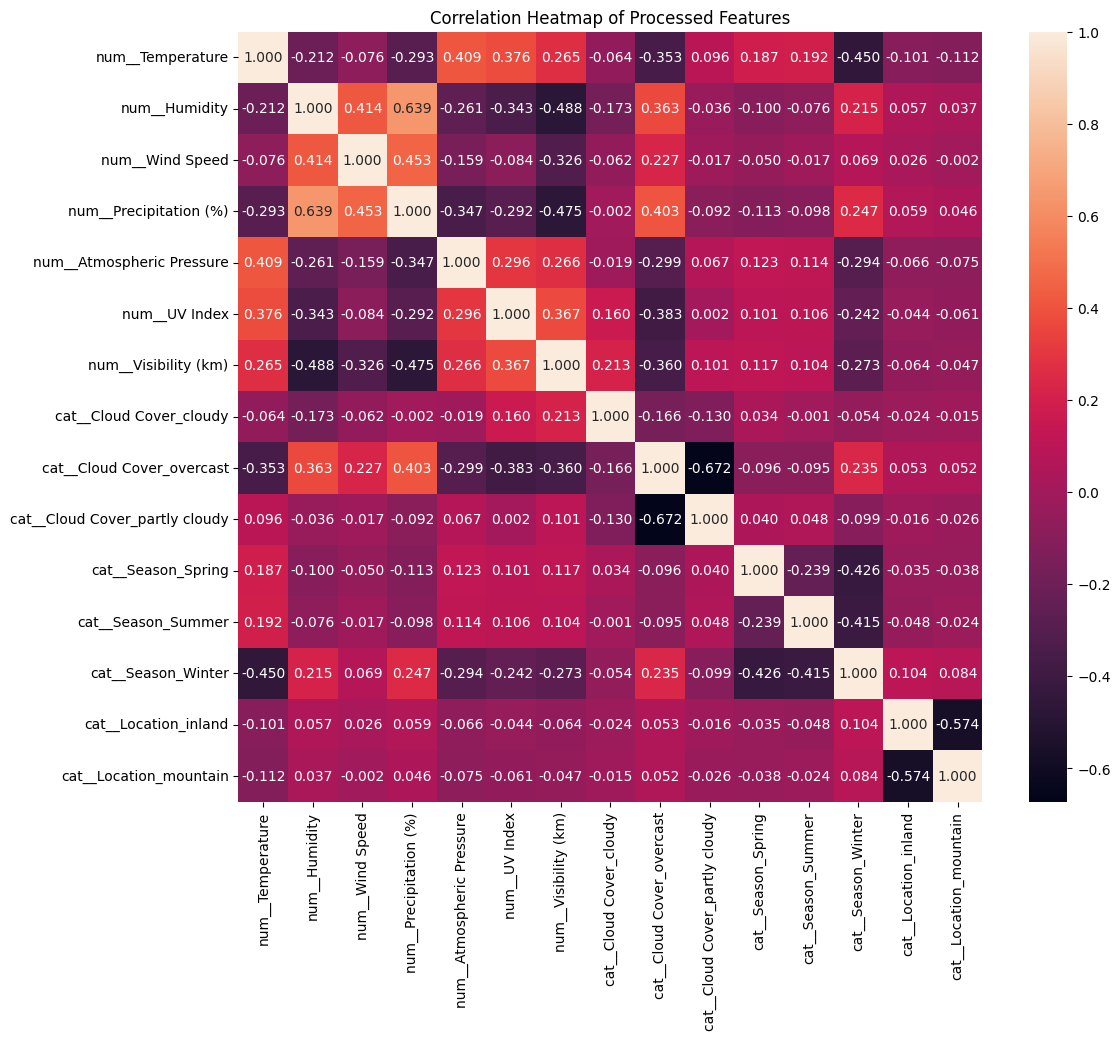

In [195]:
plt.figure(figsize=(12, 10))
sns.heatmap(x_processed_df.corr(), annot=True, fmt=".3f")
plt.title("Correlation Heatmap of Processed Features")
plt.show()
#Check for multicollinearity using VIF
#Create a dataframe which has column names and associated VIF value for each column.


In [159]:
#Check for multicollinearity using VIF
#Create a dataframe which has column names and associated VIF value for each column.
vif_df = pd.DataFrame({'Variable': x.columns, 
                       'VIF' : [vif(x.values, i) for i in range(x.shape[1])]
                      })

vif_df

,Variable,VIF
0,num__Temperature,1.502182
1,num__Humidity,1.984657
2,num__Wind Speed,1.351627
3,num__Precipitation (%),2.080524
4,num__Atmospheric Pressure,1.072096
5,num__UV Index,1.490144
6,num__Visibility (km),1.559035
7,cat__Cloud Cover_cloudy,1.361757
8,cat__Cloud Cover_overcast,6.003311
9,cat__Cloud Cover_partly cloudy,3.688127


Because any of the VIF variable values are greater than 5 __THERE IS NO MULTICOLINEARITY__ between the predictables on the dataset.  

#### TRAINING & TEST SPLIT 

In [239]:
X_40 = x.copy()
Y_40 = y.copy()

60/40

In [240]:
#Split the data
x_40_train, x_40_test, Y_40_train, Y_40_test = train_test_split(x, y, test_size=0.4, random_state = 19)

In [241]:
x_40_train.shape

(7920, 1)

In [242]:
x_40_test.shape

(5280, 1)

In [243]:
#Multiple Linear Regression
lr_40 = LinearRegression() #Model Building
lr_40.fit(x_40_train, Y_40_train) #Model Training

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [244]:
Y_40_pred = lr_40.predict(x_40_test)
Y_40_pred

array([ 0.19501674, -0.0772872 ,  0.05704941, ..., -0.03734929,
        0.13692523, -0.04461072], shape=(5280,))

In [245]:
#Find the line slope
lr_40.coef_

array([-0.00363072])

In [246]:
#FInd the line intercept
lr_40.intercept_

np.float64(0.2930461517289738)

In [247]:
#Predict data
Y_40_pred = lr_40.predict(x_40_test)
Y_40_pred

array([ 0.19501674, -0.0772872 ,  0.05704941, ..., -0.03734929,
        0.13692523, -0.04461072], shape=(5280,))

In [248]:
Y_40_test.head()

1092     0
10991    0
6597     0
4164     0
445      0
Name: Dryness_Label_Wildfire, dtype: int64

In [249]:
#Dataframe for predicted and actual values
results_diff = pd.DataFrame({'Predicted Value': Y_40_pred, 'Actual Value': Y_40_test})
results_diff

,Predicted Value,Actual Value
1092,0.195017,0
10991,-0.077287,0
6597,0.057049,0
4164,-0.073656,0
445,0.009850,0
...,...,...
6316,0.111510,0
3013,0.053419,0
9880,-0.037349,0
3901,0.136925,0


In [250]:
results_diff['Actual Value'].unique()

array([0, 1])

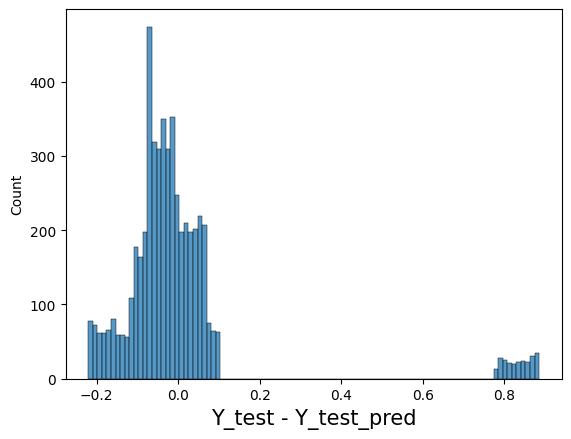

In [251]:
#Plot the histogram for the error/cost function
fig = plt.figure()
sns.histplot(Y_40_test - Y_40_pred)
plt.xlabel('Y_test - Y_test_pred', fontsize = 15)
plt.show()

In [252]:
#Compute the metrics
mae = mean_absolute_error(Y_40_test, Y_40_pred)
mse = mean_squared_error(Y_40_test, Y_40_pred)
r2 = r2_score(Y_40_test, Y_40_pred)

print('Mean Absolute Error: ', mae)
print('Mean Squared Error: ', mse)
print('R2 coefficient: ', r2)

Mean Absolute Error:  0.09823481987365398
Mean Squared Error:  0.037938878941927455
R2 coefficient:  0.12905458362973743


---

90/10

In [230]:
X_10 = x.copy()
Y_10 = y.copy()

In [231]:
#Split the data
x_10_train, x_10_test, Y_10_train, Y_10_test = train_test_split(x, y, test_size=0.1, random_state = 19)

In [232]:
#Multiple Linear Regression
lr_10 = LinearRegression() #Model Building
lr_10.fit(x_10_train, Y_10_train) #Model Training

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [233]:
#Find the line slope
lr_10.coef_

array([-0.00363847])

In [234]:
#FInd the line intercept
lr_10.intercept_

np.float64(0.2937379802409685)

In [235]:
#Predict data
Y_10_pred = lr_10.predict(x_10_test)
Y_10_pred

array([ 0.19549938, -0.0773856 ,  0.05723766, ...,  0.13728392,
       -0.02644707,  0.06087612], shape=(1320,))

In [236]:
#Dataframe for predicted and actual values
results_diff = pd.DataFrame({'Predicted Value': Y_10_pred, 'Actual Value': Y_10_test})
results_diff

,Predicted Value,Actual Value
1092,0.195499,0
10991,-0.077386,0
6597,0.057238,0
4164,-0.073747,0
445,0.009938,0
...,...,...
11395,0.097261,0
8142,-0.051916,0
11083,0.137284,0
281,-0.026447,0


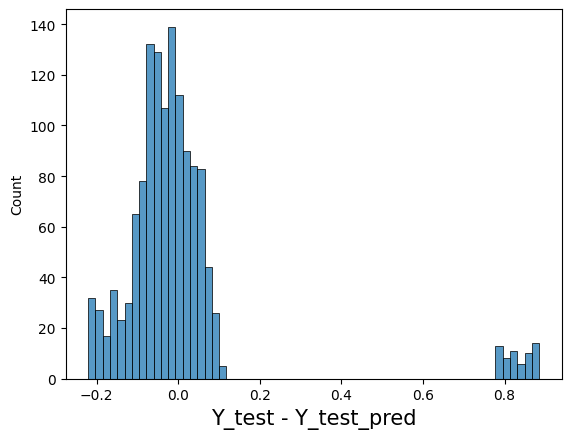

In [237]:
#Plot the histogram for the error/cost function
fig = plt.figure()
sns.histplot(Y_10_test - Y_10_pred)
plt.xlabel('Y_test - Y_test_pred', fontsize = 15)
plt.show()

In [238]:
#Compute the metrics
mae = mean_absolute_error(Y_10_test, Y_10_pred)
mse = mean_squared_error(Y_10_test, Y_10_pred)
r2 = r2_score(Y_10_test, Y_10_pred)

print('Mean Absolute Error: ', mae)
print('Mean Squared Error: ', mse)
print('R2 coefficient: ', r2)

Mean Absolute Error:  0.09870580611047627
Mean Squared Error:  0.03879481718476343
R2 coefficient:  0.13333902427391386


SIMPLE LINEAR REGRESSION: Making the simpler model possible to check if there is any problem on the Multiple Linear regression model performed above.

To do this test is necessary to select the most correlated features between the dataset, then it will be the most important predictable variable.

In [186]:
x_processed_df.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_inland,cat__Location_mountain,cat__Dryness_Label_Wildfire_Not Dry
0,-0.294931,0.212404,-0.048086,0.887629,0.134203,-0.520104,-0.582231,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.143035,1.351385,-0.192836,0.543291,0.150602,0.776424,1.345768,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.625367,-0.233285,-0.409962,-1.178401,0.346579,0.257813,0.010999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.085516,0.707613,-1.206089,0.887629,0.549008,0.776424,-1.323769,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.452811,0.261924,1.037543,0.386773,-0.407490,-0.779410,-0.878846,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [202]:
x = df[["Humidity"]]
Y = df["Dryness_Label_Wildfire"]
# Split the data

In [207]:
def define_dryness_for_wildfire(row):
    if row["Precipitation (%)"] < 10 and row["Humidity"] < 50 and row["Temperature"] > 25:
        return "Dry"
    else:
        return "Not Dry"

df["Dryness_Label_Wildfire"] = df.apply(define_dryness_for_wildfire, axis=1)
print("\nValue counts for Dryness_Label_Wildfire:")
print(df["Dryness_Label_Wildfire"].value_counts())

# Target variable for classification (1 for Dry, 0 for Not Dry)
y = (df["Dryness_Label_Wildfire"] == "Dry").astype(int)


Value counts for Dryness_Label_Wildfire:
Dryness_Label_Wildfire
Not Dry    12618
Dry          582
Name: count, dtype: int64


In [203]:
x.shape

(13200, 1)

In [208]:
x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=19)

In [209]:
#Find the best fit line in Simple linear regression
lr = LinearRegression()
lr.fit(x_train, Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [211]:
#Predict data
Y_pred = lr.predict(x_test)
Y_pred

array([ 0.19419095, -0.07676115,  0.05690855, ...,  0.11109897,
        0.17612748,  0.11109897], shape=(2640,))

In [212]:
#Find the line slope
lr.coef_

array([-0.00361269])

In [213]:
#FInd the line intercept
lr.intercept_

np.float64(0.29173370767554957)

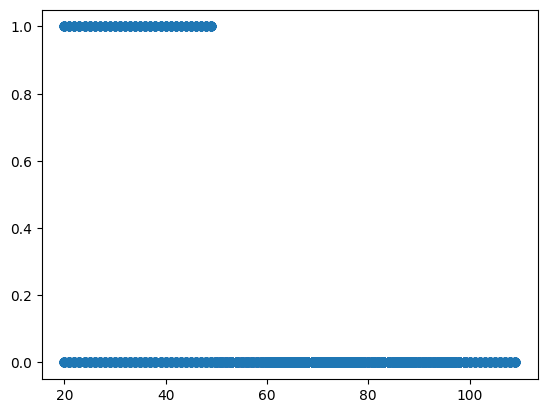

In [217]:
plt.scatter(x_train, Y_train)
plt.show()

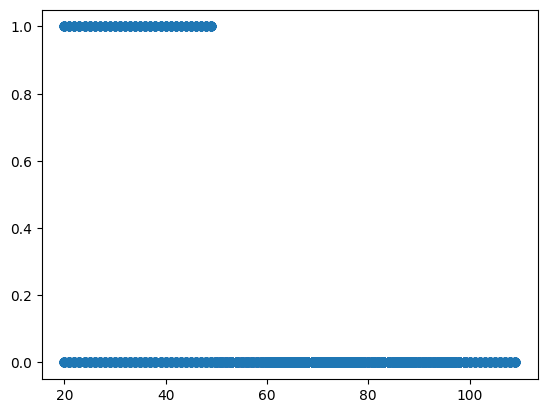

In [218]:
plt.scatter(x_train, Y_train)
plt.show()

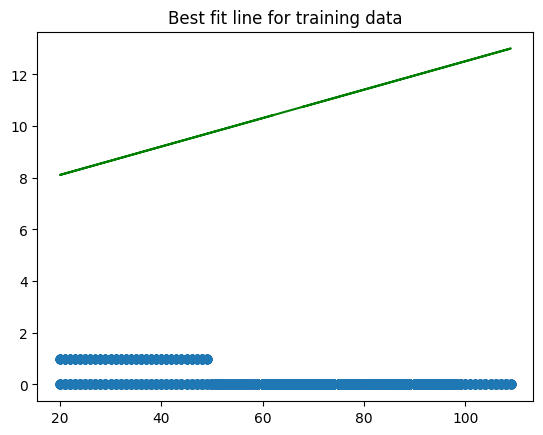

In [224]:
#Plot the best fit line for training data
plt.scatter(x_train, Y_train)
plt.plot(x_train, 0.055*x_train + 7.007, 'g')
plt.title('Best fit line for training data')
plt.show()

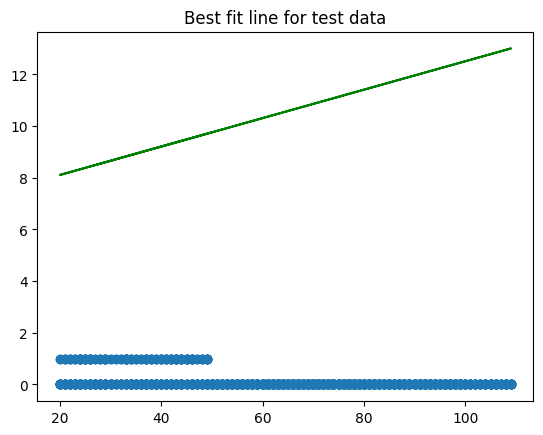

In [220]:
#Plot the best fit line for test data
plt.scatter(x_test, Y_test)
plt.plot(x_test, 0.055*x_test + 7.007, 'g')
plt.title('Best fit line for test data')
plt.show()

In [225]:
#Dataframe for predicted and actual values
results_diff = pd.DataFrame({'Predicted Value': Y_pred, 'Actual Value': Y_test})
results_diff

,Predicted Value,Actual Value
1092,0.194191,0
10991,-0.076761,0
6597,0.056909,0
4164,-0.073148,0
445,0.009944,0
...,...,...
4356,0.042458,0
4514,-0.055085,0
9376,0.111099,0
1797,0.176127,0


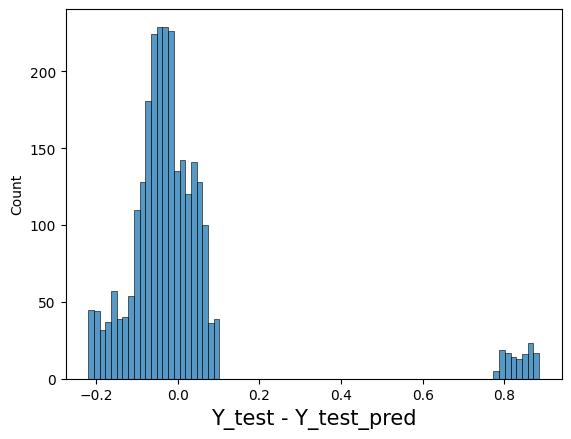

In [227]:
#Plot the histogram for the error/cost function
fig = plt.figure()
sns.histplot(Y_test - Y_pred)
plt.xlabel('Y_test - Y_test_pred', fontsize = 15)
plt.show()

In [228]:
#Compute the metrics
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print('Mean Absolute Error: ', mae)
print('Mean Squared Error: ', mse)
print('R2 coefficient: ', r2)

Mean Absolute Error:  0.09836115566949943
Mean Squared Error:  0.03885118765674918
R2 coefficient:  0.13207973007436558


### Conclusion:

Out of 60/40 and 90/10 split, 90/10 split is slightly considered a best model, but because the both results are with low percentage the model isn't efficient to predict the Dryness weather conditions.

Another Strategy to try to improve that model is play around with the columns and find a best way to follow the direction to make the model works for what is was made for. 

### 60/40 Split
* Mean Absolute Error:  0.09823481987365398
* Mean Squared Error:  0.037938878941927455
* R2 coefficient:  0.12905458362973743


### 90/10 Split Results

* Mean Absolute Error:  0.09870580611047627
* Mean Squared Error:  0.03879481718476343
* R2 coefficient:  0.13333902427391386